# The Evaluation Theatre notebook only runs in jupyter notebook
Let JenD know if you need it with jupyter lab.

In [1]:
import doctest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score,confusion_matrix, precision_recall_fscore_support
from ipywidgets import Video, Image 

In [2]:
!jupyter nbextension list
# (you need to see both jupyter-js-widgets/extension and jupyter-video/extension enabled and validated below)
# !jupyter nbextension enable --py --sys-prefix widgetsnbextension
# !pip install Jupyter-Video_Widget
# !jupyter nbextension enable --py --sys-prefix jpy_video

Known nbextensions:
  config dir: /root/anaconda3/etc/jupyter/nbconfig
    notebook section
      jupyter-js-widgets/extension  enabled 
      - Validating: OK
      jupyter-video/extension  enabled 
      - Validating: OK


In [3]:
df = pd.read_csv('../TSN_predix_multiclass.csv',index_col=0,header=0)

In [4]:
df.rename(columns={'class':'label'},inplace=True)

In [5]:
df.head()

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
13432,heavy_bag_drills_slice105.mp4,Lance,3,3,3,3
10918,NV_630.mp4,Jen,0,0,0,0
12665,V_980.mp4,Alex,0,1,0,0
15187,streetfight5_slice680.mp4,Ahsen,0,0,0,0
11420,SouthAmericanDrumline_slice35.mp4,Ahsen,0,0,0,0


In [45]:
# Multiclass case
gt_labels = {0:'NoPunch',\
            1:'ViolentPunchContact',\
            2:'ViolentPunchWithoutContact',\
            3:'NonviolentPunchContact',\
            4:'NonviolentPunchWithoutContact'}
print('Predictions')
print(df['predix'].value_counts())
print('Ground Truth')
print(df['label'].value_counts())

Predictions
0    812
1    191
3     37
4     19
2      1
Name: predix, dtype: int64
Ground Truth
0    763
1    213
3     49
4     27
2      8
Name: label, dtype: int64


In [46]:
# Verify the prediction file has a column named 'predix'
def predix_col_must_be_present(x):
    """Return whether prediction file contains column named 'predix'

    >>> predix_col_must_be_present(df)
    True
    """
    return 'predix' in x.columns

# Verify we're only predicting 1=punch or else 0=no_punch at this time
# def should_predict_binary_only(x):
#     """Return set of unique values of model predictions.

#     >>> should_predict_binary_only(df)
#     {0, 1}
#     """
#     return set(x['predix'].unique())

# Verify we're not making predictions on any excluded videos
def no_excluded_videos_should_be_predicted(x):
    """Return count of videos predicted that should have been excluded
    
    >>> no_excluded_videos_should_be_predicted(df)
    0
    """
    return x.index.intersection(df[df['label'] == -1].index).shape[0]

if __name__ == '__main__':
    import doctest
    doctest.testmod()

In [47]:
df.columns

Index(['clip_title', 'labeler', 'label', 'RGB_Preds', 'Flow_Preds', 'predix'], dtype='object')

In [48]:
# Show plain old accuracy
acc = accuracy_score(y_true=df['label'],\
              y_pred=df['predix'])
print(f"Overall accuracy of this model is: {acc:.2%}")

Overall accuracy of this model is: 84.72%


In [49]:
print(f"{df['label'].value_counts()[0]/df.shape[0]:.2%} of our test set was labeled NO-PUNCH")

71.98% of our test set was labeled NO-PUNCH


In [50]:
# Show precision_recall_fscore_support per label JUST BINARY FOR NOW
raw_report = precision_recall_fscore_support(y_true=df['label'], y_pred=df['predix'],labels=[0,1,2,3,4])
report = pd.DataFrame(raw_report, index=['precision','recall','fscore','support'],\
                     columns=gt_labels.values())
report

,NoPunch,ViolentPunchContact,ViolentPunchWithoutContact,NonviolentPunchContact,NonviolentPunchWithoutContact
precision,0.880542,0.738220,0.0,0.810811,0.631579
recall,0.937090,0.661972,0.0,0.612245,0.444444
fscore,0.907937,0.698020,0.0,0.697674,0.521739
support,763.000000,213.000000,8.0,49.000000,27.000000


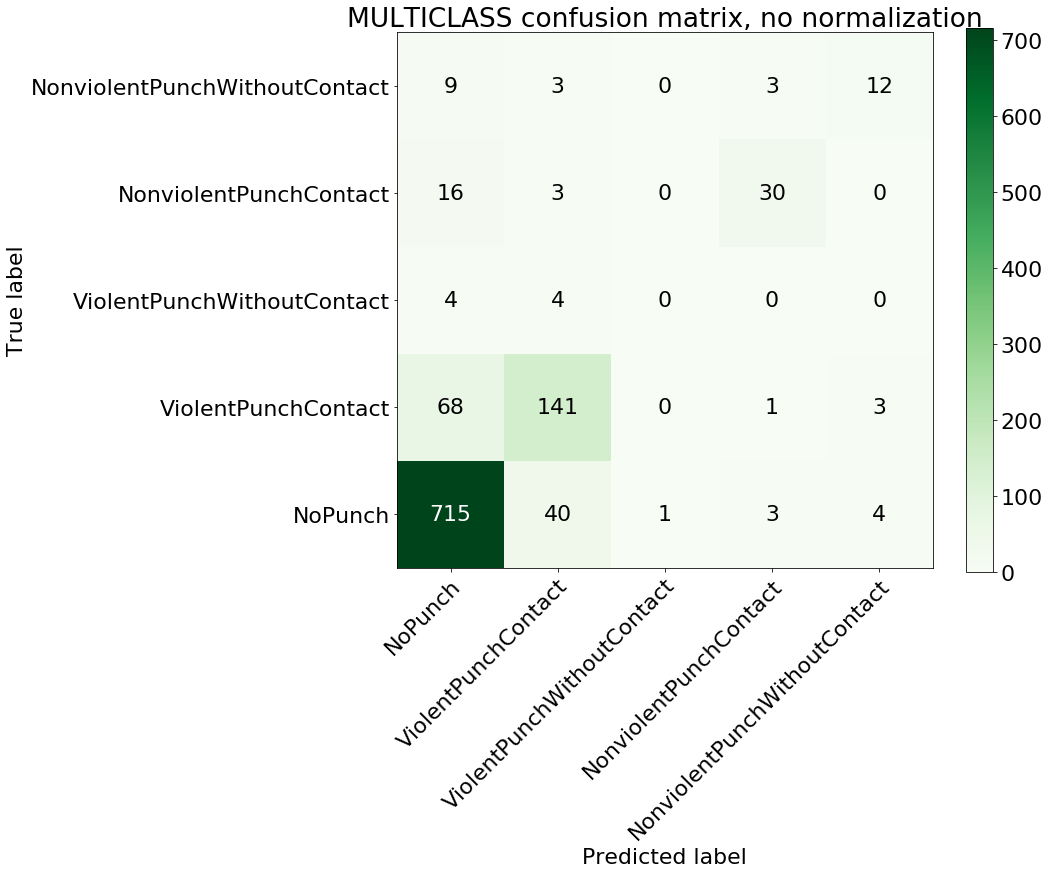

In [51]:
def plot_confusion_matrix(y_true, y_pred, labels,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_xlim(left=-0.5, right=4.5)
    ax.set_ylim(bottom=-0.5, top=4.5)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(df['label'], df['predix'], labels=gt_labels.values(),
                      title='MULTICLASS confusion matrix, no normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(df['label'], df['predix'], labels=gt_labels.values(), normalize=True,
#                       title='Normalized MULTICLASS confusion matrix')

plt.savefig("confusion_matrix_raw.png",bbox_inches='tight')
plt.show()

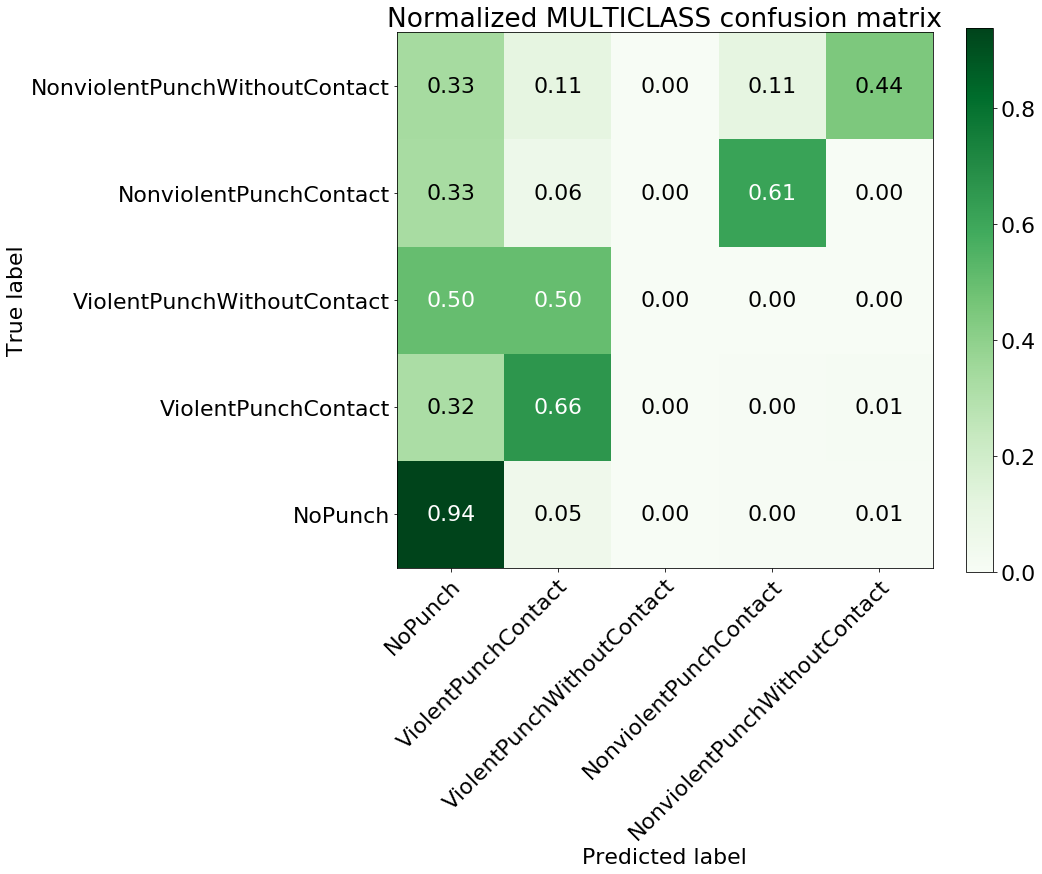

In [52]:
plt.rcParams.update({'font.size': 22})
# Plot normalized confusion matrix
plot_confusion_matrix(df['label'], df['predix'], labels=gt_labels.values(), normalize=True,
                      title='Normalized MULTICLASS confusion matrix')

plt.savefig("confusion_matrix_normalized.png",bbox_inches='tight')
plt.show()

In [53]:
# Multiclass samples
def resample():
    samples={}
    for truth in range(0,5):
        samples[truth]={}
        for pred in range(0,5):
            if bool(df[(df['label']==truth) & (df['predix']==pred)].shape[0]):
                samples[truth][pred] = df[(df['label']==truth) & (df['predix']==pred)].sample(1)
    return samples

In [54]:
def fetch_sample(real,predicted,sampledict):
    truth_target = sampledict.get(real,None)
    if truth_target:
        pred_target = truth_target.get(predicted,None)
        return pred_target

The clips that have ground truth of no punch and are also predicted as no punch make up ~72% of our test set. Load the below cell several times for some examples:

In [29]:
show = None
c00 = fetch_sample(0,0,resample())
truth,inference = 'NO-PUNCH','same'
if 'DataFrame' in str(type(c00)):
    clip, judge = c00.head(1)['clip_title'].iloc[0],c00.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

NO-PUNCH clip predicted as same [kicks_line_dance_slice125.mp4 brought to you by Jen]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\rS6mdat\x00\x00\x0…

In 40 cases, our TSN predicts a violent punch where there is no punch labeled. In looking at samples of these, many are kicks that may still warrant attention from security staff. For instance, see V_132_slice0.mp4 and V_801.mp4. In our edge-screening scenario, these would be sent to the cloud for further analysis.

In [55]:
show = None
c01 = fetch_sample(0,1,resample())
truth,inference = 'NO-PUNCH','Violent Punch'
if 'DataFrame' in str(type(c01)):
    clip, judge = c01.head(1)['clip_title'].iloc[0],c01.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

NO-PUNCH clip predicted as Violent Punch [balcony_football_violence__Football_Hooligans_Leeds_v_Wolves_2005__MorningGlory1997__f66MTrNLPL0.mp4 brought to you by Alex]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\xa6Emdat\x00\x…

What about the clips that were labeled as containing a violent punch, yet are not predicted to contain a violent punch? This sample constitutes nearly a third of clips labeled as violent punches. Play some examples below. In the case of streetfight4_slice535.mp4, perhaps it's a slap.

In [56]:
show = None
c10 = fetch_sample(1,0,resample())
truth,inference = 'VIOLENT PUNCH','NO-PUNCH'
if 'DataFrame' in str(type(c10)):
    clip, judge = c10.head(1)['clip_title'].iloc[0],c10.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

VIOLENT PUNCH clip predicted as NO-PUNCH [soccer_violence__Chinese_kungfu_soccer__crazyzibe__Gsrc7AXC_kI_slice10.mp4 brought to you by Lance]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03\xcb\xb4mdat\x0…

Below, watch clips that were properly predicted to contain a violent punch with contact

In [86]:
show = None
c11 = fetch_sample(1,1,resample())
truth,inference = 'Violent Punch with Contact','same'
if 'DataFrame' in str(type(c11)):
    clip, judge = c11.head(1)['clip_title'].iloc[0],c11.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

Violent Punch with Contact clip predicted as same [V_864.mp4 brought to you by Lance]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08d\xd0mdat\x00\x…

In [58]:
show = None
c02 = fetch_sample(0,2,resample())
truth,inference = 'no-punch','violent swing and miss'
if 'DataFrame' in str(type(c02)):
    clip, judge = c02.head(1)['clip_title'].iloc[0],c02.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

no-punch clip predicted as violent swing and miss [streetfight3_slice610.mp4 brought to you by Ahsen]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\n\xd1\xefmdat\x00\…

In [65]:
show = None
c20 = fetch_sample(2,0,resample())
truth,inference = 'violent swing and miss','no-punch'
if 'DataFrame' in str(type(c02)):
    clip, judge = c20.head(1)['clip_title'].iloc[0],c20.head(1)['labeler'].iloc[0]
    print(f"{truth} clip predicted as {inference} [{clip} brought to you by {judge}]".format())
    show = Video.from_file('/root/vids/' + clip)
show

violent swing and miss clip predicted as no-punch [V_722.mp4 brought to you by Lance]


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02Lfmdat\x00\x00\…

In [6]:
df.sample(10)

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
12216,V_638.mp4,Lance,1,1,1,1
14957,streetfight4_slice180.mp4,Jen,1,0,0,0
13728,how_to_strike_max_power_slice20.mp4,Lance,4,4,4,4
11732,V_20.mp4,Alex,1,1,1,1
10102,ByronBay_slice235.mp4,Ahsen,0,0,0,0
11810,V_276_slice0.mp4,Alex,1,1,1,1
14418,stadium_violence__soccer_riot_compilation__qqc...,Jen,1,1,1,1
10065,British_Football_Hooligans_Mix_3__MorningGlory...,Jen,0,0,0,0
14799,streetfight2_slice610.mp4,Ahsen,0,0,0,0


In [8]:
df[df['clip_title'].str.contains('fist')]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14049,obama_fist_bumps_slice0.mp4,Lance,0,0,0,0


In [8]:
clip = "streetfight3_slice610.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=0; predix=2
# i can certainly see where that would look like a swing/miss to algo

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\n\xd1\xefmdat\x00\…

In [5]:
df[df['clip_title'].str.contains('fist')]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14049,obama_fist_bumps_slice0.mp4,Lance,0,0,0,0


In [7]:
df[(df['label']==0) & (df['predix']==2)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14926,streetfight3_slice610.mp4,Ahsen,0,2,2,2


In [9]:
df[(df['label']==0) & (df['predix']==3)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
13040,downward_strike_punches_slice875.mp4,Lance,0,3,0,3
12978,downward_strike_punches_slice595.mp4,Ahsen,0,3,3,3
14358,short_strikes_slice625.mp4,Alex,0,3,3,3


In [11]:
clip = "downward_strike_punches_slice595.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=0; predix=3
# i can certainly see why the algo would consider this as a strike with contact, even though we labeled not punch

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x18\xb8\xc4mdat\x0…

In [12]:
clip = "short_strikes_slice625.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=0; predix=3

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x13\xb8\xfbmdat\x0…

In [13]:
df[(df['label']==0) & (df['predix']==4)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
13632,how_to_punch_7_basics_slice265.mp4,Lance,0,4,4,4
13439,heavy_bag_drills_slice140.mp4,Ahsen,0,4,0,4
13605,how_to_punch_7_basics_slice145.mp4,Jen,0,4,4,4
15241,stunt_fights_shayna_slice140.mp4,Ahsen,0,4,0,4


In [17]:
clip = "how_to_punch_7_basics_slice265.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=0; predix=4

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0bFSmdat\x00\x00\…

In [18]:
df[(df['label']==1) & (df['predix']==3)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14043,mitt_drill_slice70.mp4,Lance,1,3,3,3


In [19]:
clip = "mitt_drill_slice70.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=1; predix=3

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\x1d\x0emdat\x0…

In [20]:
df[(df['label']==1) & (df['predix']==4)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
13671,how_to_punch_hard_fast_slice160.mp4,Lance,1,1,4,4
13665,how_to_punch_hard_fast_slice135.mp4,Lance,1,4,2,4
15234,stunt_fights_shayna_slice105.mp4,Jen,1,0,4,4


In [23]:
clip = "stunt_fights_shayna_slice105.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=1; predix=4

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\x99Xmdat\x00\x…

In [24]:
df[(df['label']==2) & (df['predix']==0)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
15083,streetfight5_slice205.mp4,Jen,2,0,0,0
12309,V_722.mp4,Lance,2,0,1,0
14755,streetfight2_slice415.mp4,Ahsen,2,0,0,0
11643,V_123_slice0.mp4,Jen,2,1,0,0


In [29]:
clip = "streetfight2_slice415.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=2; predix=0
# definitely looks like a camera angle problem

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x16B\x00mdat\x00\x…

In [30]:
df[(df['label']==2) & (df['predix']==1)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
12593,V_916.mp4,Ahsen,2,1,1,1
12070,V_505_slice0.mp4,Alex,2,1,1,1
12130,V_560_slice0.mp4,Alex,2,1,0,1
14907,streetfight3_slice525.mp4,Jen,2,1,1,1


In [31]:
clip = "V_916.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=2; predix=1
# definitely swings and misses; good that security will be called

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04\x91\xf4mdat\x0…

In [32]:
clip = "V_505_slice0.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=2; predix=1
# I can't tell if there's contact; certainly seems violent

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\t\xad\x06mdat\x00\…

In [34]:
clip = "streetfight3_slice525.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=2; predix=1

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10%\xf8mdat\x00\x…

In [37]:
df[(df['label']==3) & (df['predix']==0)]


,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
13772,how_to_strike_max_power_slice40.mp4,Lance,3,0,0,0
12953,downward_strike_punches_slice485.mp4,Lance,3,0,0,0
14190,perfect_hook_punch_slice60.mp4,Lance,3,3,1,0
4167,short_strikes_slice485.mp4,Lance,3,0,0,0
14046,mitt_drill_slice85.mp4,Ahsen,3,0,0,0
13983,mitt_drill_slice110.mp4,Lance,3,0,0,0
12875,downward_strike_punches_slice1610.mp4,Alex,3,0,0,0
13028,downward_strike_punches_slice820.mp4,Alex,3,0,0,0
3851,mitt_drill_slice245.mp4,Lance,3,3,0,0


In [45]:
clip = "NV_434.mp4" 
show = Video.from_file('/root/vids/' + clip)
show
# label=3; predix = 0
# I think I agree with the model more than with Lance

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x01t\xc6mdat\x00\x…

In [46]:
clip = "perfect_hook_punch_slice60.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=3; predix = 0
# it's a mystery to me why the model didn't get this one. checking its probability
# at least it's not that confident: 41%

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x12\xb0\xccmdat\x0…

In [47]:
df[(df['label']==3) & (df['predix']==1)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14165,perfect_hook_punch_slice220.mp4,Alex,3,3,1,1
15243,stunt_fights_shayna_slice15.mp4,Alex,3,3,1,1
11960,V_406.mp4,Alex,3,0,1,1


In [48]:
clip = "perfect_hook_punch_slice220.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=3; predix = 1
# maybe absence of glob on puncher?

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10\x87\x02mdat\x0…

In [50]:
clip = "V_406.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=3; predix = 1

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x04g\x88mdat\x00\x…

In [51]:
df[(df['label']==4) & (df['predix']==0)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14174,perfect_hook_punch_slice260.mp4,Jen,4,0,0,0
4012,perfect_hook_punch_slice25.mp4,Alex,4,0,0,0
2755,downward_strike_punches_slice20.mp4,Alex,4,0,0,0
13598,how_to_punch_7_basics_slice110.mp4,Jen,4,4,0,0
12922,downward_strike_punches_slice345.mp4,Lance,4,3,0,0
13872,how_to_strike_max_power_slice850.mp4,Jen,4,0,0,0
15232,stunt_fights_shayna_slice10.mp4,Alex,4,4,0,0
11392,PutHandsUp_slice70.mp4,Lance,4,0,0,0
10181,French_flashmob_circle_slice345.mp4,Lance,4,0,0,0


In [52]:
clip = "French_flashmob_circle_slice345.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=4; predix = 0

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x1b\xe2\xd1mdat\x0…

In [54]:

clip = "downward_strike_punches_slice345.mp4" 
show = Video.from_file('/root/vids/' + clip)
show
# label=4; predix = 0

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x16\xdf}mdat\x00\x…

In [55]:
clip = "PutHandsUp_slice70.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=4; predix = 0

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x08\x95\xbdmdat\x0…

In [56]:
df[(df['label']==4) & (df['predix']==1)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
14018,mitt_drill_slice270.mp4,Jen,4,0,1,1
13675,how_to_punch_hard_fast_slice180.mp4,Ahsen,4,1,1,1
12322,V_734.mp4,Jen,4,1,0,1


In [59]:
clip = "V_734.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=4; predix = 1

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x02d\x99mdat\x00\x…

In [60]:
df[(df['label']==4) & (df['predix']==3)]

,clip_title,labeler,label,RGB_Preds,Flow_Preds,predix
video-UID,,,,,,
2964,fast_punch_drill_slice145.mp4,Ahsen,4,3,3,3
14254,short_strikes_slice155.mp4,Ahsen,4,3,3,3
3313,heavy_bag_drills_slice300.mp4,Ahsen,4,3,3,3


In [61]:
clip = "fast_punch_drill_slice145.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=4; predix = 3
# I disagree with Ahsen here; I think he is making contact with the bag

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x11\xbammdat\x00\x…

In [62]:
clip = "short_strikes_slice155.mp4"
show = Video.from_file('/root/vids/' + clip)
show
# label=4; predix = 3
# camera angle again, as arms overlap at end

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x17\x13\x8fmdat\x0…